 # Customer Segmentation using Clustering

 ---

 **Internship Task 2:** Customer Segmentation

 **Tools Used:** Python, Pandas, Matplotlib, Seaborn, Scikit-learn

 **Objective:** Cluster mall customers into segments based on Annual Income and Spending Score, and explore alternative clustering methods.

 ## 1. Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


 ## 2. Load Dataset

In [2]:
mall_file_path = '../data/Mall_Customers.csv'
mall_customer = pd.read_csv(mall_file_path)
mall_customer.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


 ## 3. Data Exploration

In [3]:
mall_customer.info()
mall_customer.describe()
print("Missing values per column:")
print(mall_customer.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
Missing values per column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


 ## 4. Initial Visualization – Income vs Spending Score

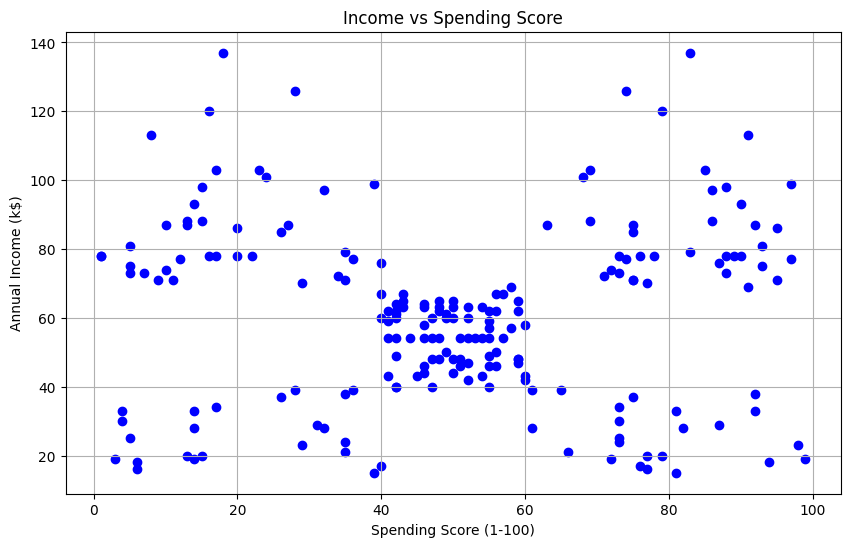

In [4]:
plt.figure(figsize=(10,6))
plt.scatter(
    mall_customer['Spending Score (1-100)'],
    mall_customer['Annual Income (k$)'],
    color='b'
)
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Annual Income (k$)')
plt.title('Income vs Spending Score')
plt.grid(True)
plt.show()


 ## 5. Feature Selection – Annual Income & Spending Score

In [5]:
income_vs_spending_score = mall_customer[['Annual Income (k$)', 'Spending Score (1-100)']]
income_vs_spending_score.head()


,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


 ## 6. Feature Scaling

In [6]:
scaler = MinMaxScaler()
X = scaler.fit_transform(income_vs_spending_score)
X.shape


(200, 2)

 ## 7. Determine Optimal Clusters – Elbow Method

In [7]:
wcss_list = []
for k in range(1, 10):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X)
    wcss_list.append(model.inertia_)


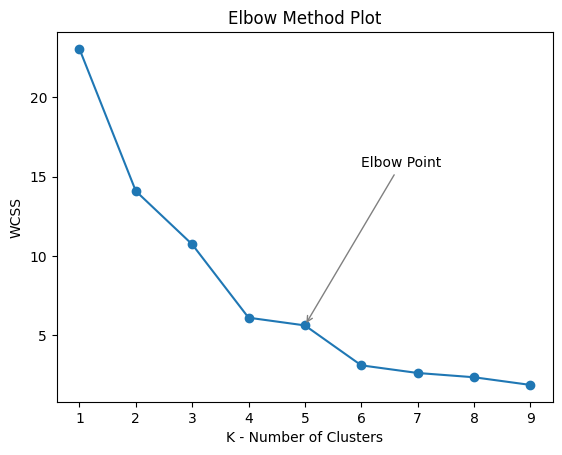

In [8]:
fig, ax = plt.subplots()
ax.plot(range(1, 10), wcss_list, marker='o')
ax.set_xlabel('K - Number of Clusters')
ax.set_ylabel('WCSS')
ax.set_title("Elbow Method Plot")

elbow_k = 5
elbow_wcss = wcss_list[elbow_k - 1]
ax.annotate('Elbow Point',
            xy=(elbow_k, elbow_wcss),
            xytext=(elbow_k + 1, elbow_wcss + 10),
            arrowprops=dict(arrowstyle='->', color='gray'))

plt.savefig('../visuals/elbow_method_plot.png', dpi=300)
plt.show()


 ## 8. Apply K-Means Clustering

In [9]:
model_KMeans = KMeans(n_clusters=5, random_state=42)
model_KMeans.fit(X)
y_means = model_KMeans.predict(X)


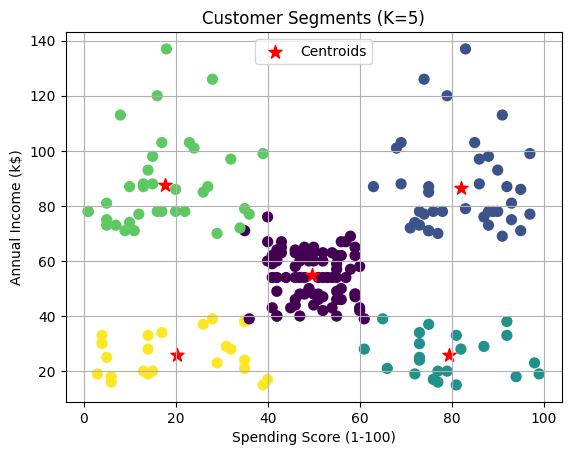

In [10]:
plt.scatter(
    income_vs_spending_score.iloc[:, 1],
    income_vs_spending_score.iloc[:, 0],
    c=y_means,
    s=50,
    cmap='viridis'
)
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Annual Income (k$)")

centroids = scaler.inverse_transform(model_KMeans.cluster_centers_)
plt.scatter(
    centroids[:, 1],
    centroids[:, 0],
    marker='*',
    s=100,
    color='red',
    label='Centroids'
)

plt.title("Customer Segments (K=5)")
plt.legend()
plt.grid(True)
plt.savefig('../visuals/customer_segments_KMeans_5.png', dpi=300)
plt.show()


 ## 9. Bonus – DBSCAN Clustering

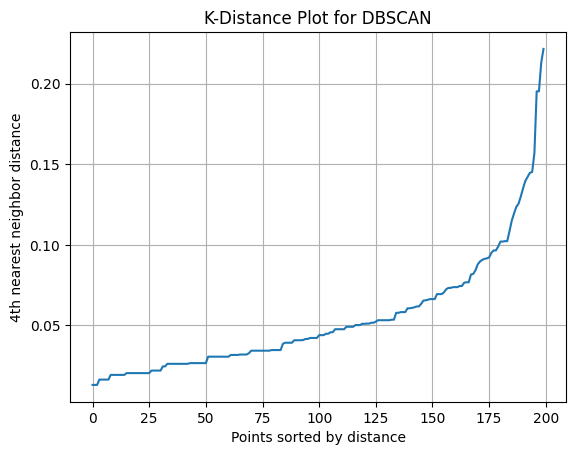

In [11]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4).fit(X)
distances, _ = neighbors.kneighbors(X)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('4th nearest neighbor distance')
plt.title('K-Distance Plot for DBSCAN')
plt.grid(True)
plt.savefig('../visuals/K_Distance_plot_for_DBSCAN.png', dpi=300)
plt.show()


In [12]:
from sklearn.cluster import DBSCAN
model_DBSCAN = DBSCAN(eps=0.12, min_samples=4)
y_dbscan = model_DBSCAN.fit_predict(X)

unique, counts = np.unique(y_dbscan, return_counts=True)
print(f"Cluster distribution: {dict(zip(unique, counts))}")


Cluster distribution: {np.int64(-1): np.int64(8), np.int64(0): np.int64(157), np.int64(1): np.int64(35)}


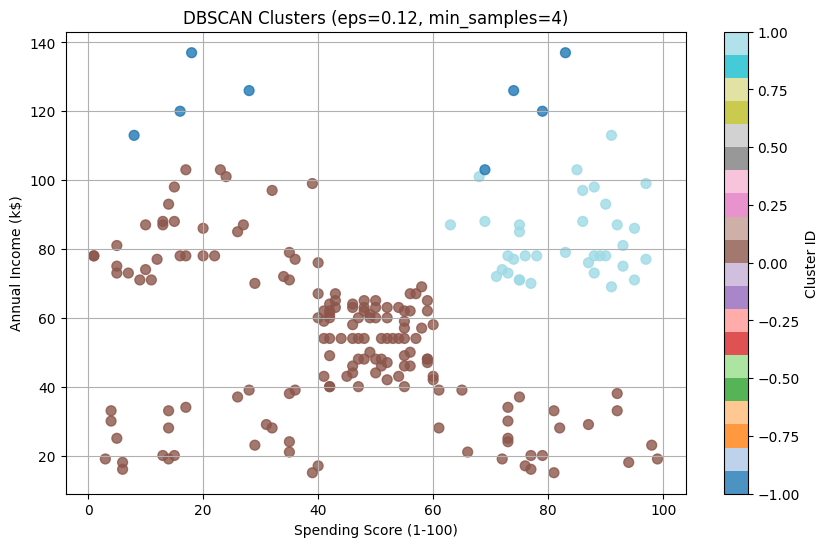

In [13]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    income_vs_spending_score.iloc[:, 1],
    income_vs_spending_score.iloc[:, 0],
    c=y_dbscan,
    cmap='tab20',
    s=50,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Annual Income (k$)")
plt.title(f"DBSCAN Clusters (eps=0.12, min_samples=4)")
plt.grid(True)
plt.savefig('../visuals/DBSCAN_clusters_eps_0.12_min_samples_4.png', dpi=300)
plt.show()


 ## 10. Analyze Average Spending per Cluster

In [14]:
mall_customer['KMeans_Cluster'] = y_means
kmeans_stats = mall_customer.groupby('KMeans_Cluster')['Spending Score (1-100)'] \
    .agg(["count", "min", "max", 'mean', "median", "std"]).round(3)
print("K-Means Cluster Stats:")
print(kmeans_stats)


K-Means Cluster Stats:
                count  min  max    mean  median     std
KMeans_Cluster                                         
0                  81   35   61  49.543    50.0   6.475
1                  39   63   97  82.128    83.0   9.364
2                  22   61   99  79.364    77.0  10.504
3                  36    1   39  17.583    16.0  10.205
4                  22    3   40  20.227    16.0  12.891


C:\Users\Acer\AppData\Local\Temp\ipykernel_13784\1991775552.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


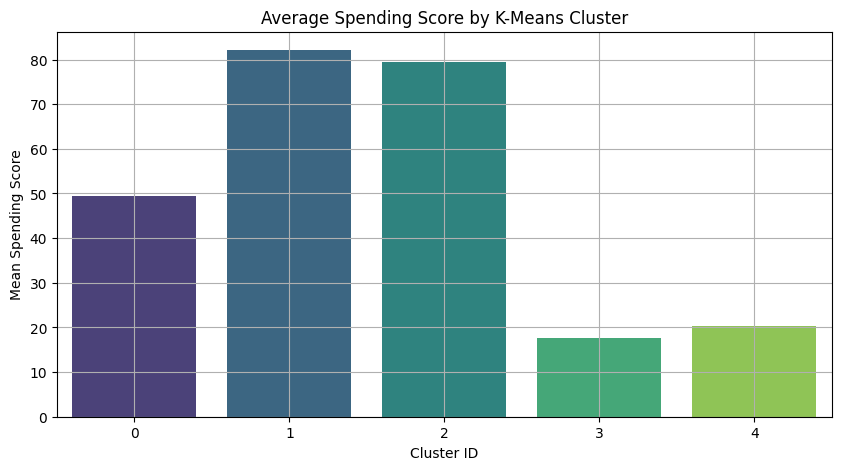

In [15]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=mall_customer,
    x='KMeans_Cluster',
    y='Spending Score (1-100)',
    estimator='mean',
    errorbar=None,
    palette='viridis'
)
plt.title('Average Spending Score by K-Means Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Spending Score')
plt.grid(True)
plt.savefig('../visuals/average_spending_score_by_KMeans_cluster.png', dpi=300)
plt.show()


In [16]:
mall_customer['DBSCAN_Cluster'] = y_dbscan
dbscan_stats = mall_customer[mall_customer['DBSCAN_Cluster'] != -1] \
    .groupby('DBSCAN_Cluster').agg({
        'Spending Score (1-100)': ["count", "min", "max", 'mean', "median", "std"],
        'Annual Income (k$)': ["count", "min", "max", 'mean', "median", "std"]
    }).round(3)

print("\nDBSCAN Cluster Stats (Excluding Noise):")
dbscan_stats



DBSCAN Cluster Stats (Excluding Noise):


Spending Score (1-100)                                 \
                                count min max    mean median     std   
DBSCAN_Cluster                                                         
0                                 157   1  99  43.102   46.0  22.249   
1                                  35  63  97  82.800   86.0   9.499   

               Annual Income (k$)                                  
                            count min  max    mean median     std  
DBSCAN_Cluster                                                     
0                             157  15  103  52.490   54.0  21.811  
1                              35  69  113  82.543   78.0  10.926

C:\Users\Acer\AppData\Local\Temp\ipykernel_13784\2027530269.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


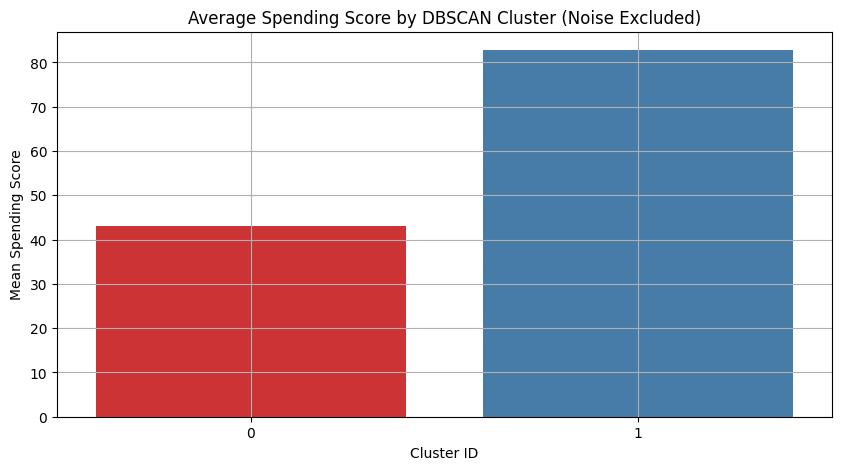

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=mall_customer[mall_customer['DBSCAN_Cluster'] != -1],
    x='DBSCAN_Cluster',
    y='Spending Score (1-100)',
    estimator='mean',
    errorbar=None,
    palette='Set1'
)
plt.title('Average Spending Score by DBSCAN Cluster (Noise Excluded)')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Spending Score')
plt.grid(True)
plt.savefig('../visuals/average_spending_score_by_DBSCAN_cluster.png', dpi=300)
plt.show()


 ## 11. Cluster Count Comparison

In [18]:
print(f"K-Means clusters: {len(np.unique(y_means))}")
print(f"DBSCAN clusters (excl. noise): {len(np.unique(y_dbscan)) - 1}")


K-Means clusters: 5
DBSCAN clusters (excl. noise): 2
